Based heavily on:
https://www.kaggle.com/kakauandme/digit-recognizer/tensorflow-deep-nn

# Libraries and settings

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# settings
LEARNING_RATE = 1e-4
# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 2500        
    
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 2000

# image number to output
IMAGE_TO_DISPLAY = 10

# Read Data

In [2]:
data = pd.read_csv('data/train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

# Convert to np.floats and to 0-1 instead of 0-255

In [3]:
images = data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)
print('images({0[0]},{0[1]})'.format(images.shape))
print(images[0])

images(42000,784)
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.      

# Convert images from stretched out array to square

In [4]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


# View image function

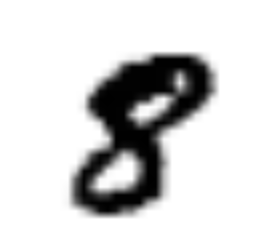

In [5]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# output image     
display(images[IMAGE_TO_DISPLAY])

# Get labels

In [6]:
labels_flat = data[[0]].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_flat(42000)
labels_flat[10] => 8
labels_count => 10


# Create one-hot vector for labels (but why?)

**Quesiton for Toph**: I've only used one-hot encoding on features that have a set number of options.  What is the benefit of using one-hot on the labels?

In [7]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


# Create validation data

**Question for Toph:** why are we taking a subset of the training data instead of just using the test data?  Is it because with the test data we don't know the label so we can't confirm how well the model is working without submitting it to Kaggle?

In [8]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(40000,784)
validation_images(2000,784)


# Begin TensorFlow

**Helper Functions**

In [9]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Creating convolution function.  Have no idea what this is, but hoping I'll start to get it once I'm more familiar with the code.

In [10]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Pooling function - this essentially reduces the size of the data we are working with by aproximating the location and taking the max value.  Better explanation here:
https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer

In [11]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

One of the benefits of Neual Networks is that the output of one NN can be used as the input to another NN.  This layering is called Deep Neural Networks.

In this case we will use two convolation layers with pooling in between them 

In [12]:
# input & output of NN
# Input = X
# Output = Y

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])
# print(x)
# print(y_)

We will now begin creating our convolution layers.  The first layer is a convolution folloewd by max pooling.  The convolution computes 32 features for each 5x5 patch.  

It's weight tensor has a shape of [5,5,1,32].  The first two dimensions are the patch size, the next is the number of input channels (1 means that images are gray scale), and the last is the number of output channels

To apply the layer we reshape the input data to a 4d tensor, with the first dimension corresponding to the number of images, second and third - to image height and width and the final dimension - the the number of color channels

**Question:** 
 - What does the line `b_conv1 = bias_variable([32])` do?

# First Convolution layer

In [13]:
# first convolutional layer
# 5x5 patch, gray scale with 32 output channels
W_conv1 = weight_variable([5, 5, 1, 32])
# what does this line do?
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
# reshape to 4d tensor
image = tf.reshape(x, [-1,image_width , image_height,1])
print (image.get_shape()) # =>(40000,28,28,1)


(?, 28, 28, 1)


After convolution pooling reduces teh size of the output from 28x28 to 14x14

In [16]:
h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

(?, 28, 28, 32)
(?, 14, 14, 32)


**Question:**
 - What exactly are we doing above?

In [19]:
# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))

layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

# Second Convolution layer

This layer will have 64 features for each 5x5 section.  It's tensor has a shape of [5,5,32,64].  The first two dimensions are the patch size, the next is the number of input channels (32 channels correspond to the 32 features that we got from our previous convolution layer) and the last dimension is the number of output channels.  There is also a bias vector with a component for each output channel.

**Questions/Notes:** 
 - What are the 32 features that we got from the first convolution layer?  Is there a real world explanation?
 - What is the "bias vector" 

Since the image is down sampled by pooling to 14x14 (instead of 28x28) the second convolution layer picks up more general characteristics of the images.  Filters cover more space of the picture.  Because of this - the second layer is better for finding more generic features while the first is better for details.

In [23]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

Now that the image size is reduced to 7x7 we add a fully connected layer with 1024 neurones to allow processing on the entire image (each of the neurons of the fully connected layer is connected to all the actiations/outputs of the previous layer)

**Questions/Notes:** 

 - Wait - when did the image get reduced to 7x7 - I thought we only reduced it to 14x14?
 - What is a "fully connected layer"?
 - why 1024 neurons? 

In [25]:
# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
print (h_fc1.get_shape()) # => (40000, 1024)

(?, 1024)


To prevent overfitting, we apply dropout before the readout layer.

Dropout removes some nodes from the network at each training stage.  Each of the nodes is either kept probability `keep_prob` or dropped with probably 1 - `keep_prob`.  After the training stage is over the nodes are returned to the NN with their original weights.

**Questions/Notes**
 - Look into logic behind keeping/dropping nodes - still confused about that.
 - Get a clearer understanding what a "node" is (when they say "...the nodes are returned...")


In [26]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Next we add a softmax layer, the sae one if we just us a simple softmax regression.

Softmax: https://en.wikipedia.org/wiki/Softmax_function

**Notes:**
 - Look into what softmax is

In [28]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

To evaluate network performance we use cross-entropy and to minimise it ADAM optimiser is used.

ADAM optimizer is a gradient based optimization algorithm, base don adaptive estimates, it's mroe sophisticated than steepest gradient descent and is well suited for problems with large data or may parameters.

**Notes/Questions**
 - Read up on ADAM optimizer: http://arxiv.org/pdf/1412.6980v8.pdf
 - Read up on cross entropy: https://en.wikipedia.org/wiki/Cross_entropy

In [29]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

To predict values from the test data we create a one hot vector with the probability for each number.

In [30]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)
print(predict)

Tensor("ArgMax_2:0", shape=(?,), dtype=int64)


Ok! The neural network structure is defined and TensorFlow graph is ready for training!

# Train, validate and predict

**Create helper functions:**

Ideally, we should use all data for every step of the training, but that's expensive.  So instead we use small batches of random data.   

This method is called stochastic training - it's cheaper aster and gives much of the same result.

**Notes/Questions:**
Read up on stochastic training: https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [32]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

Now when all operations for every variable are defined in TensorFlow graph all computations will be performed otuside the Python Environment

In [33]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

Each step of the loop, we get a batch of data points from the training set and feed it to the graph to replace the placeholders.  In this case, it's x, y and dropout.

**Question:**
 - What exactly do x, y and dropout reference in out example?  Position on the image?

Also - once in a while we check training accuracy on an upcoming batch

On the local environment we recommend saving training process so it can be recovered for further training, debugging or evaluation

In [34]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.06 / 0.04 for step 0
training_accuracy / validation_accuracy => 0.10 / 0.04 for step 1
training_accuracy / validation_accuracy => 0.12 / 0.16 for step 2
training_accuracy / validation_accuracy => 0.10 / 0.16 for step 3
training_accuracy / validation_accuracy => 0.18 / 0.20 for step 4
training_accuracy / validation_accuracy => 0.18 / 0.20 for step 5
training_accuracy / validation_accuracy => 0.18 / 0.20 for step 6
training_accuracy / validation_accuracy => 0.24 / 0.24 for step 7
training_accuracy / validation_accuracy => 0.30 / 0.24 for step 8
training_accuracy / validation_accuracy => 0.20 / 0.22 for step 9
training_accuracy / validation_accuracy => 0.26 / 0.26 for step 10
training_accuracy / validation_accuracy => 0.38 / 0.48 for step 20
training_accuracy / validation_accuracy => 0.44 / 0.48 for step 30
training_accuracy / validation_accuracy => 0.66 / 0.70 for step 40
training_accuracy / validation_accuracy => 0.80 / 0.72 for step 50
train

**Question:**
 - What exactly are we looping through here?  What are the training itterations?

In [35]:
print(TRAINING_ITERATIONS)
print(BATCH_SIZE)

2500
50


After traiing ids done check the accuracy on data tha twasn't used in training.

validation_accuracy => 0.9820


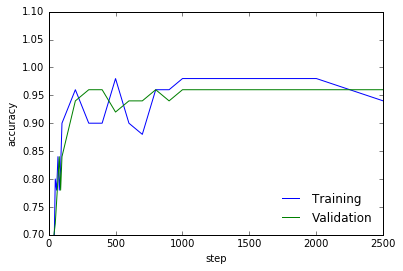

In [36]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

Once we are happy with the outcome we can read test data from test.csv and predict labels for provided images.  

Test data contains only images (labels are missing).  Otherwise the structure is similar to the training data.

Predicted labels are stored in to CSV file for future submissions

test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 5.0
predicted_lables[98] => 7.0
predicted_lables[200] => 1.0


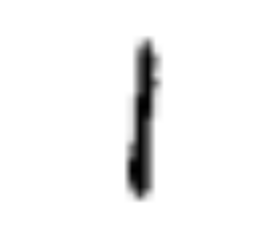

In [40]:
# read test data from CSV file 
test_images = pd.read_csv('data/test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

display(test_images[98])
print ('predicted_lables[{0}] => {1}'.format(98,predicted_lables[98]))

display(test_images[200])
print ('predicted_lables[{0}] => {1}'.format(200,predicted_lables[200]))

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

# Appendix

As mentioned above it is good to output some variables to better understand the process.

Here we pull an output of the first convolution layer from the TensorFlow graph.  32 features are transformed into an image and it's quite interesting to see how filters picked by NN outline characteristics of different digits.

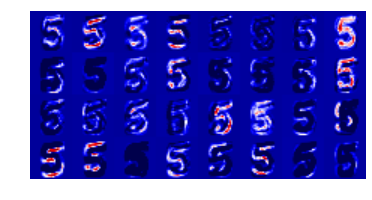

In [41]:
layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )


In [ ]:
sess.close()